<a href="https://colab.research.google.com/github/lincolnck/eeg_seizure/blob/master/EEG_seizures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from string import ascii_letters

from sklearn import decomposition, neighbors, svm, metrics, tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, adjusted_rand_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.metrics import Precision, Accuracy



url = 'https://raw.githubusercontent.com/lincolnck/eeg_seizure/master/eeg_data.csv'
df = pd.read_csv(url)

df

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,...,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,-38,-10,35,64,113,152,164,127,50,-47,-121,-138,-125,-101,-50,11,39,24,48,64,46,13,-19,-61,-96,-130,-132,-116,-115,-71,...,54,90,111,107,64,32,18,-25,-69,-65,-44,-33,-57,-88,-114,-130,-114,-83,-53,-79,-72,-85,-109,-98,-72,-65,-63,-11,10,8,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,232,237,258,212,2,-267,-605,-850,-1001,-1109,-1090,-967,-746,-464,-152,118,318,427,473,485,447,397,339,312,314,326,335,332,324,310,...,27,146,229,269,297,307,303,305,306,307,280,231,159,85,51,43,62,63,63,69,89,123,136,127,102,95,105,131,163,168,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,-99,-94,-96,-104,-103,-92,-75,-69,-69,-53,-37,-14,-10,-39,-78,-102,-98,-80,-54,-40,-35,-39,-32,-13,7,34,41,33,6,...,-82,-107,-126,-124,-108,-84,-68,-61,-56,-63,-62,-33,1,28,45,37,48,62,80,66,23,-11,-39,-44,-42,-45,-48,-42,-6,29,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,-72,-68,-74,-80,-83,-73,-68,-61,-58,-59,-64,-79,-84,-97,-94,-84,-77,-75,-72,-68,-76,-76,-72,-67,-69,-69,-69,-67,-68,...,-69,-66,-74,-69,-61,-51,-45,-45,-49,-58,-64,-78,-80,-90,-87,-83,-78,-64,-38,-22,-29,-42,-51,-68,-71,-69,-69,-74,-74,-80,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,-90,-103,-84,-43,-9,3,-21,-60,-96,-103,-75,-29,14,55,78,73,28,-13,-43,-68,-78,-75,-55,-41,-19,-20,-29,-36,-20,...,38,26,10,-4,-13,-8,0,10,19,29,57,63,45,7,-13,-23,-9,9,11,3,-1,-2,4,18,27,27,14,15,11,10,4,2,-12,-32,-41,-65,-83,-89,-73,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,X22.V1.114,-22,-22,-23,-26,-36,-42,-45,-42,-45,-49,-57,-64,-73,-79,-76,-70,-63,-57,-57,-50,-45,-34,-33,-32,-30,-24,-24,-18,-9,-2,0,2,-3,-5,-13,-23,-39,-53,-59,...,45,55,60,69,68,58,54,44,40,38,39,39,32,23,22,14,13,15,18,20,20,25,28,29,29,29,26,24,24,20,15,16,12,5,-1,-18,-37,-47,-48,2
11496,X19.V1.354,-47,-11,28,77,141,211,246,240,193,136,78,8,-66,-132,-180,-210,-227,-225,-212,-192,-168,-144,-117,-88,-54,-21,6,29,46,60,76,92,110,128,152,171,150,91,21,...,69,58,38,16,25,75,165,260,343,406,456,471,461,412,319,175,-5,-171,-293,-357,-378,-370,-346,-316,-278,-241,-201,-162,-126,-94,-65,-33,-7,14,27,48,77,117,170,1
11497,X8.V1.28,14,6,-13,-16,10,26,27,-9,4,14,-1,-10,14,44,77,61,42,32,29,22,26,35,81,66,50,57,91,121,111,73,38,23,35,21,11,-12,2,17,61,...,-90,-62,-38,-40,-21,-23,-11,-4,-9,-22,-42,-49,-48,-40,-40,-46,-43,-67,-67,-50,-18,-14,-39,-74,-86,-75,-68,-57,-78,-42,-65,-48,-61,-62,-67,-30,-2,-1,-8,5
11498,X10.V1.932,-40,-25,-9,-12,-2,12,7,19,22,29,22,6,1,-28,-37,-35,-35,-45,-64,-105,-140,-157,-157,-147,-153,-147,-126,-112,-83,-56,-41,-40,-38,-34,-47,-41,-40,-42,-49,...,-98,-77,-60,-73,-88,-97,-118,-108,-100,-97,-91,-109,-122,-134,-137,-107,-95,-67,-54,-40,-31,-19,7,22,46,68,87,97,105,114,121,135,148,143,116,86,68,59,55,3


In [4]:
df = df.drop(df.columns[[0]], axis=1)

sequence = df.drop(df.columns[-1], axis=1)
target = df.iloc[:, [-1]]

eeg = df.to_numpy()

X = eeg[:,:178]
y = eeg[:,178]
X.shape,y.shape

((11500, 178), (11500,))

In [29]:
for i in np.arange(0,len(y)):
  if y[i] == 1:
    y[i] = 1
  else:
    y[i] = 0
y

sequence_train = sequence[0:9200].to_numpy().astype('int32')

target_train = target[0:9200].to_numpy().flatten()
target_train[target_train>1]=0
target_train_cat = np_utils.to_categorical(target_train)

sequence_test = sequence[9200:].to_numpy().astype('int32')

target_test = target[9200:].to_numpy().flatten()
target_test[target_test>1]=0
target_test_cat = np_utils.to_categorical(target_test)

In [6]:
def pred_test_ratio(y_pred,y_test):
  score =0
  max_score =0
  for i in np.arange(0,len(y_test)):
    if (y_test[i] == 1):
      max_score+=1
      if (y_pred[i] == 1):
        score+=1
  return score/max_score

# Principle Component Analysis

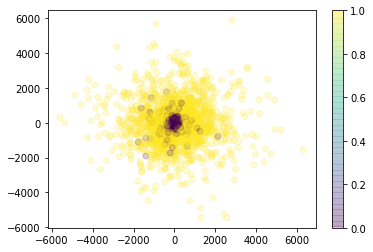

In [7]:
pca = decomposition.PCA(n_components=X.shape[1], whiten=False)
B = pca.fit_transform(X)
E, L = pca.components_.T, pca.explained_variance_

plt.scatter(B[:,0],B[:,1],c = y,alpha=0.2);
plt.colorbar()

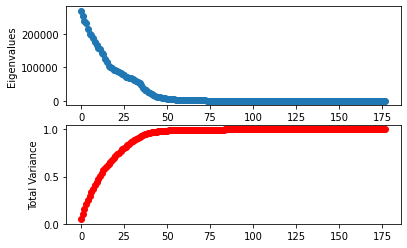

In [8]:
subplot(211); plot(L,'o-'); ylabel('Eigenvalues');
subplot(212); cl=np.cumsum(L); ylabel('Total Variance');
plot(cl/cl[-1],'o-r'); ylim(0,None);

# KNN Classifier

Classification Accuracy: 0.9521739130434783
10-fold Cross Validation Accuracy: 0.952 (+/- 0.015)
Adjusted Rand Index: 0.7795091449173056


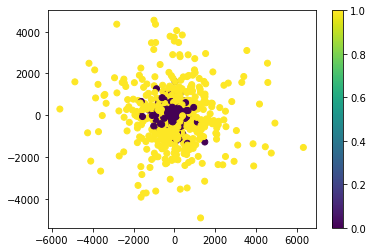

In [9]:
X_train, X_test, y_train, y_test = train_test_split(B[:,:50], y, test_size=0.30)

NN1 = neighbors.KNeighborsClassifier(1)
pred = NN1.fit(X_train,y_train).predict(X_test)

plt.scatter(X_test[:,0],X_test[:,1],c = pred)
colorbar()

print ('Classification Accuracy:', (pred==y_test).sum()/len(y_test))
scores = cross_val_score(NN1, X, y, cv=10)
print("10-fold Cross Validation Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
print ('Adjusted Rand Index:', adjusted_rand_score(y_test,pred))

# Support Vector Machine


Classification Accuracy: 0.9733333333333334
10-fold Cross Validation Accuracy: 0.973 (+/- 0.008)
Adjusted Rand Index: 0.8786781292068421


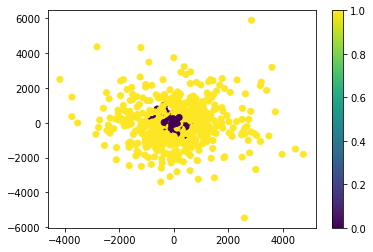

In [10]:
X_train, X_test, y_train, y_test = train_test_split(B[:,:50], y, test_size = 0.30)

clf = svm.SVC()
pred = clf.fit(X_train,y_train).predict(X_test)

plt.scatter(X_test[:,0],X_test[:,1],c=pred)
colorbar()

print('Classification Accuracy:', (pred==y_test).sum()/len(y_test))
scores = cross_val_score(clf, X, y, cv=10)
print("10-fold Cross Validation Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
print('Adjusted Rand Index:',adjusted_rand_score(y_test,pred))

# Random Forest Classifier

Classification Accuracy: 0.976231884057971
10-fold Cross Validation Accuracy: 0.975 (+/- 0.007)
Adjusted Rand Index: 0.8930433896624381


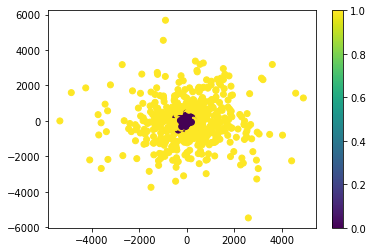

In [11]:
X_train, X_test, y_train, y_test = train_test_split(B[:,:50], y, test_size = 0.30)


clf = RandomForestClassifier(n_estimators = 200)
pred = clf.fit(X_train,y_train).predict(X_test)

plt.scatter(X_test[:,0],X_test[:,1],c=pred)
colorbar()

print('Classification Accuracy:', (pred==y_test).sum()/len(y_test))
scores = cross_val_score(clf, X, y, cv=10)
print("10-fold Cross Validation Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
print('Adjusted Rand Index:', adjusted_rand_score(y_test,pred))

# Gaussian Naive Bayes

Classification Accuracy: 0.957391304347826
10-fold Cross Validation Accuracy: 0.957 (+/- 0.005)
Adjusted Rand Index 0.8112382994259827
predict pos 0.9002976190476191


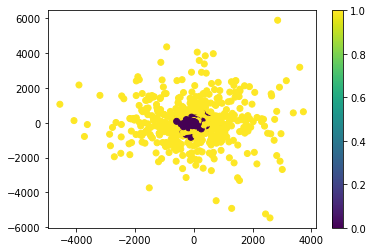

In [12]:
X_train, X_test, y_train, y_test = train_test_split(B[:,:50], y, test_size = 0.30)

gnb = GaussianNB()
pred = gnb.fit(X_train, y_train).predict(X_test)

plt.scatter(X_test[:,0],X_test[:,1],c=pred)
colorbar()

print('Classification Accuracy:', (pred==y_test).sum()/len(y_test))
scores = cross_val_score(gnb, X, y, cv=10)
print("10-fold Cross Validation Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
print("Adjusted Rand Index", adjusted_rand_score(pred, y_test))
print("predict pos", pred_test_ratio(pred,y_test))

In [13]:
model_lstm_sequence_train = sequence_train.reshape(9200, 178, 1) 

In [14]:
model_lstm = Sequential([
    LSTM(100, input_shape=(178, 1), return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [15]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [16]:
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
model_lstm.fit(model_lstm_sequence_train, target_train, epochs=2)

Epoch 1/2
288/288 [==============================] - 67s 232ms/step - loss: 0.0633 - accuracy: 0.9764
Epoch 2/2
288/288 [==============================] - 46s 159ms/step - loss: 0.0921 - accuracy: 0.9666


In [26]:
model_lstm_sequence_test = sequence_test.reshape(2300, 178, 1) 
pred = model_lstm.predict(model_lstm_sequence_test)

In [33]:
scores = model_lstm.evaluate(model_lstm_sequence_test, target_test)

72/72 [==============================] - 6s 63ms/step - loss: 0.0741 - accuracy: 0.9730
